In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_dir = '/content/drive/MyDrive/PCB_DATASET'

In [3]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 36.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

In [5]:
dataset_dir = root_dir

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/content/drive/MyDrive/PCB_DATASET/Annotations
/content/drive/MyDrive/PCB_DATASET/images
/content/drive/MyDrive/PCB_DATASET/PCB_USED
/content/drive/MyDrive/PCB_DATASET/rotation
/content/drive/MyDrive/PCB_DATASET/images_resized
/content/drive/MyDrive/PCB_DATASET/output
/content/drive/MyDrive/PCB_DATASET/Annotations/Spurious_copper
/content/drive/MyDrive/PCB_DATASET/Annotations/Open_circuit
/content/drive/MyDrive/PCB_DATASET/Annotations/Mouse_bite
/content/drive/MyDrive/PCB_DATASET/Annotations/Missing_hole
/content/drive/MyDrive/PCB_DATASET/Annotations/Spur
/content/drive/MyDrive/PCB_DATASET/Annotations/Short
/content/drive/MyDrive/PCB_DATASET/images/Spurious_copper
/content/drive/MyDrive/PCB_DATASET/images/Spur
/content/drive/MyDrive/PCB_DATASET/images/Short
/content/drive/MyDrive/PCB_DATASET/images/Open_circuit
/content/drive/MyDrive/PCB_DATASET/images/Mouse_bite
/content/drive/MyDrive/PCB_DATASET/images/Missing_hole
/content/drive/MyDrive/PCB_DATASET/rotation/Mouse_bite_rotation
/cont

In [6]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [7]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


In [8]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [9]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [10]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_spurious_copper_07.jpg,3034,1586,spurious_copper,2578,741,2642,770
1,01_spurious_copper_07.jpg,3034,1586,spurious_copper,2613,863,2648,953
2,01_spurious_copper_07.jpg,3034,1586,spurious_copper,1811,861,1961,917
3,01_spurious_copper_03.jpg,3034,1586,spurious_copper,1539,866,1574,962
4,01_spurious_copper_03.jpg,3034,1586,spurious_copper,1854,948,1904,1043


In [11]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [12]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image

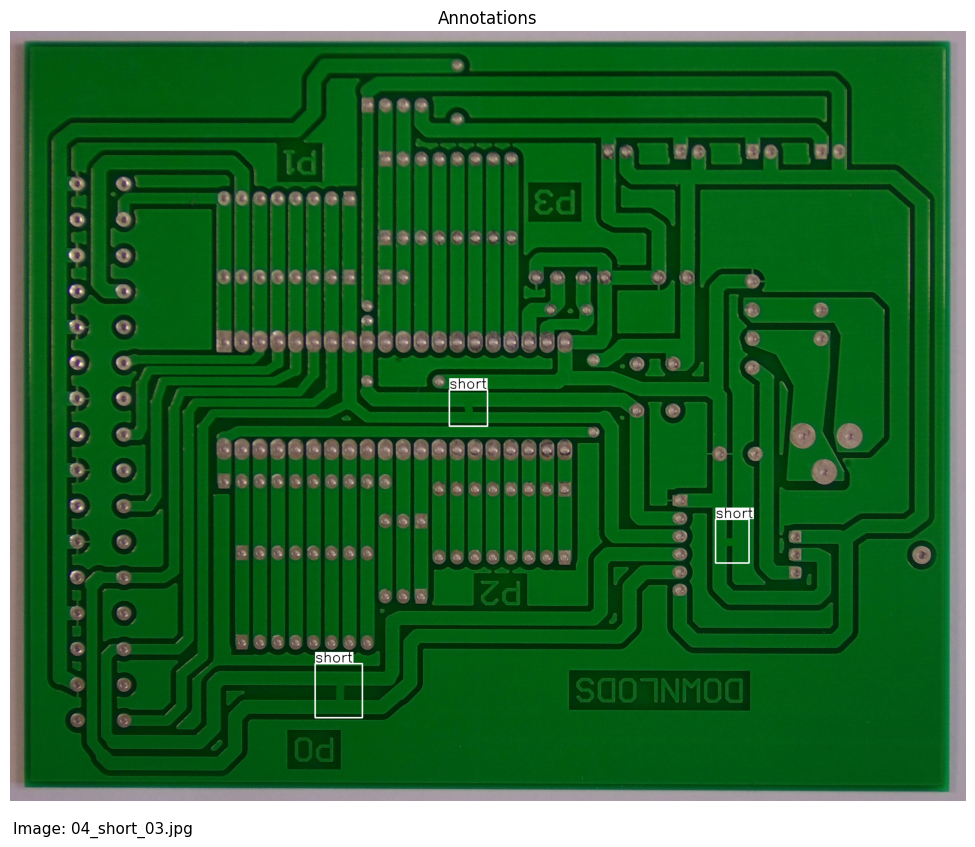

In [13]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

In [14]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [15]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_spurious_copper_07.jpg,640,640,spurious_copper,543,299,557,310
1,01_spurious_copper_07.jpg,640,640,spurious_copper,551,348,558,384
2,01_spurious_copper_07.jpg,640,640,spurious_copper,382,347,413,370
3,01_spurious_copper_03.jpg,640,640,spurious_copper,324,349,332,388
4,01_spurious_copper_03.jpg,640,640,spurious_copper,391,382,401,420


In [16]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [17]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)

In [18]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

In [19]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [20]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [21]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [22]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

,0,1,2,3,4,5
01_missing_hole_01,6.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_02,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_03,6.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_04,6.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_05,8.0,0.0,0.0,0.0,0.0,0.0


In [23]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [24]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

In [25]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

,0,1,2,3,4,5
split_1,0.542429,0.571906,0.526917,0.459936,0.583748,0.366379
split_2,0.581911,0.540984,0.504823,0.450637,0.451368,0.569307
split_3,0.389805,0.39881,0.469388,0.598246,0.471495,0.585


In [26]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [27]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [28]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

In [29]:
# Train the model
model = YOLO('yolov8s.pt')
results = {}

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 180
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml,
                epochs=epochs,
                batch=batch,
                lr0=0.001,
                lrf=0.0001,
                imgsz=imgsz,
                save_period=save_period,
                verbose=verbose,
                project=project,
                mixup=mixup)
    results[k] = model.metrics

100%|██████████| 21.5M/21.5M [00:00<00:00, 231MB/s]


Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/split_1_dataset.yaml, epochs=180, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False

100%|██████████| 755k/755k [00:00<00:00, 41.8MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 163MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/labels... 603 images, 0 backgrounds, 0 corrupt: 100%|██████████| 603/603 [00:14<00:00, 41.96it/s]

train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/images/01_missing_hole_01.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/images/01_missing_hole_03.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/images/01_missing_hole_05.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/images/01_missing_hole_06.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/images/01_missing_hole_07.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/images/01_missing_hole_12.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/images/01_missing_hole_13.jpg

train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/labels... 370 images, 0 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:11<00:00, 32.23it/s]

val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/images/01_missing_hole_04.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/images/01_missing_hole_09.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/images/01_missing_hole_10.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/images/01_missing_hole_11.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/images/01_missing_hole_17.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/images/01_missing_hole_18.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/images/01_missing_hole_19.jpg: 3 duplicate labels removed

val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/labels.cache
Plotting labels to pcb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb/train
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      4.07G      3.923      18.45      1.936         95        640: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]

                   all        370       1569   0.000462     0.0541   0.000278   0.000108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      4.07G      2.963      3.925      1.295         72        640: 100%|██████████| 38/38 [00:09<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


                   all        370       1569      0.232      0.334      0.237      0.087

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      3.91G      2.616      2.934      1.186         69        640: 100%|██████████| 38/38 [00:09<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


                   all        370       1569      0.429      0.497      0.414      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      4.06G      2.449      2.522      1.143         87        640: 100%|██████████| 38/38 [00:09<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]


                   all        370       1569      0.583      0.493      0.506      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      3.88G      2.388      2.206      1.114         89        640: 100%|██████████| 38/38 [00:09<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]


                   all        370       1569      0.676       0.51      0.559      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      4.03G      2.323      2.056      1.092        120        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


                   all        370       1569       0.78      0.651      0.709      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      4.05G      2.244        1.9      1.082         65        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]


                   all        370       1569      0.793      0.603      0.711      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      3.91G      2.187      1.813      1.074         50        640: 100%|██████████| 38/38 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]


                   all        370       1569      0.914      0.664      0.803      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      3.88G       2.24      1.782      1.076         55        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]


                   all        370       1569      0.826      0.695       0.77      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180       4.1G       2.16      1.675      1.055        104        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]


                   all        370       1569      0.901      0.721      0.798      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      4.06G      2.186      1.752      1.058         88        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]


                   all        370       1569      0.888      0.737       0.84      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180       3.9G      2.152        1.7      1.039         74        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        370       1569      0.903      0.703      0.803      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      4.07G      2.103      1.621      1.039         95        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


                   all        370       1569      0.903      0.773      0.852      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      4.07G      2.055      1.552      1.036         50        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        370       1569      0.916      0.822      0.873      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      4.01G      2.121      1.601      1.036         96        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


                   all        370       1569      0.923      0.808      0.879      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      3.89G      2.075      1.519      1.023         83        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


                   all        370       1569      0.881      0.801      0.854      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      3.87G      2.017      1.485      1.024         78        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


                   all        370       1569      0.935      0.808      0.889      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180       4.1G       2.06      1.513      1.028         70        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        370       1569      0.922       0.81       0.88      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      3.88G      2.022      1.456      1.027         65        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        370       1569      0.914      0.839      0.902      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      4.07G      2.031      1.455      1.019         67        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        370       1569      0.929      0.838      0.902       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      4.07G      1.966      1.411      1.011        103        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        370       1569      0.932      0.845      0.908      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      4.06G      1.992      1.375      1.016         81        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]


                   all        370       1569      0.889      0.838      0.901       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      3.89G      1.972      1.406      1.009         60        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        370       1569      0.943       0.84      0.913      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      4.11G      1.975      1.373      1.003         65        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        370       1569      0.886      0.849        0.9      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180       3.9G      1.975      1.394      1.006        115        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.943      0.875      0.925      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      4.06G      1.967      1.369     0.9953         95        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        370       1569      0.953       0.86      0.932      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      3.89G      1.913      1.314      0.991        104        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


                   all        370       1569      0.926      0.855      0.919      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      4.05G      1.924      1.284     0.9949         66        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]


                   all        370       1569      0.924      0.869      0.917      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      4.08G      1.956      1.358     0.9993         57        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        370       1569      0.946      0.868      0.927      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      3.93G      1.932      1.343     0.9851         94        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        370       1569      0.946      0.874      0.929      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      4.07G      1.908      1.307     0.9929         69        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        370       1569      0.954      0.872      0.932      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.07G      1.937      1.304     0.9871        107        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


                   all        370       1569      0.953       0.86      0.921      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180      3.91G      1.967      1.352     0.9943         54        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        370       1569      0.921      0.872      0.927      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      3.89G      1.908      1.306     0.9916        121        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        370       1569      0.941      0.878      0.931      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.08G      1.876      1.275     0.9836         64        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        370       1569      0.959      0.857      0.927      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      4.06G      1.861      1.208     0.9708         51        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.957      0.879      0.931      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      3.87G      1.844      1.199     0.9641         44        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.48it/s]

                   all        370       1569      0.948      0.887      0.935      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180       3.9G      1.862      1.236     0.9773         65        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        370       1569      0.957      0.893      0.939       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      3.88G      1.879       1.21     0.9816         85        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.942      0.874      0.931      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      3.92G      1.858       1.25     0.9802         58        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.951      0.896      0.938      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.08G      1.897      1.257     0.9734         59        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        370       1569      0.949      0.894      0.946      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      3.89G      1.843      1.176     0.9728         59        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        370       1569      0.943      0.893      0.941      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180         4G      1.849      1.207     0.9736        101        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        370       1569      0.974      0.885      0.951      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180       3.9G       1.81      1.184     0.9716         58        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        370       1569      0.954      0.889      0.942      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      3.83G      1.795      1.152     0.9672         70        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        370       1569      0.948      0.917      0.949       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      4.08G      1.824      1.179     0.9693        106        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.951      0.894      0.946      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      4.03G      1.824      1.173     0.9668         65        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        370       1569      0.946      0.896      0.945      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180       4.1G      1.802       1.17     0.9638         68        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        370       1569       0.97      0.892      0.952      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      3.91G      1.805      1.194     0.9596        101        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        370       1569       0.96       0.91      0.945      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      4.06G      1.803      1.178     0.9549         72        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        370       1569      0.952      0.907       0.95      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      3.87G      1.826      1.199     0.9731         71        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        370       1569      0.932      0.922      0.948      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.08G      1.776      1.122     0.9528         63        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.955      0.912      0.952      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      3.85G       1.83      1.194     0.9606         64        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        370       1569       0.96      0.908      0.954      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      4.06G      1.778      1.132     0.9493         87        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        370       1569      0.957      0.922      0.956        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      3.99G      1.817      1.168     0.9667        100        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        370       1569      0.955      0.925      0.955      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      4.04G      1.763      1.102     0.9458         93        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        370       1569      0.975      0.906      0.953      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      3.88G      1.772      1.136     0.9526         72        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        370       1569      0.979      0.892      0.944      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      3.89G      1.778       1.11      0.952        106        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        370       1569      0.953      0.924      0.956      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180      4.08G      1.808      1.179     0.9651         79        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        370       1569      0.947      0.907      0.945       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      4.06G      1.752      1.123     0.9579         86        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        370       1569      0.931      0.906      0.942      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      3.92G      1.767      1.126     0.9597         96        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        370       1569      0.974      0.907      0.952      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.05G       1.73       1.09     0.9497         95        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        370       1569      0.965      0.908      0.953      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180         4G      1.767      1.127     0.9557         87        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        370       1569      0.967      0.914      0.955      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.07G      1.729      1.077     0.9452         74        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.981      0.893      0.956      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.04G      1.742      1.077     0.9441         97        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        370       1569      0.961      0.921      0.963       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      3.89G      1.745      1.116     0.9494         66        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

                   all        370       1569      0.968      0.928      0.962      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      3.88G      1.753      1.112     0.9524         89        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        370       1569      0.974      0.917      0.964      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      3.93G      1.711      1.047       0.94         81        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        370       1569      0.963      0.919       0.96      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.04G      1.727      1.066     0.9406         55        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

                   all        370       1569      0.956      0.941      0.966      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      4.09G      1.706      1.035     0.9424         80        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        370       1569       0.97      0.915       0.96      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      4.04G      1.736       1.08     0.9409         66        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        370       1569      0.963      0.916      0.956      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      4.01G      1.696      1.022     0.9343         69        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        370       1569      0.964       0.93       0.96      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.08G      1.689      1.009     0.9346         62        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        370       1569       0.97      0.942      0.963      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.07G      1.712      1.061     0.9405         94        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.967      0.934      0.965       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180         4G      1.726       1.09     0.9465         90        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        370       1569      0.966      0.935      0.964      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.08G       1.67      1.016      0.936         59        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        370       1569       0.96      0.945      0.967      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      3.89G      1.702      1.035     0.9441         78        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        370       1569      0.963      0.932      0.964      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      3.93G      1.686       1.04     0.9322         89        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        370       1569      0.967      0.933      0.966      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      3.84G      1.713      1.078     0.9368         90        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        370       1569      0.973      0.931      0.967      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      4.06G      1.716      1.032     0.9414         81        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        370       1569      0.967      0.935      0.964      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      4.03G      1.683      1.011     0.9333         71        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        370       1569      0.969      0.934      0.968      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.07G       1.67     0.9974     0.9313         57        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        370       1569      0.975      0.931      0.965      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      3.88G      1.667       1.03     0.9293         83        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        370       1569      0.979      0.926      0.969      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      4.06G      1.679      1.043     0.9324         82        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        370       1569      0.963      0.936      0.963      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180      3.91G      1.668      1.011     0.9393         79        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        370       1569      0.969      0.944      0.969      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180      3.93G      1.654     0.9921      0.926         33        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        370       1569      0.963      0.936      0.965      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      3.88G      1.653      1.024     0.9388         82        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.84it/s]

                   all        370       1569      0.967      0.934      0.967      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      3.92G      1.684       1.02     0.9444         51        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.974      0.929      0.965      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      4.07G      1.636     0.9903     0.9315        103        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        370       1569      0.973      0.933      0.967      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180       4.1G      1.674      1.021     0.9329        104        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        370       1569      0.967      0.942      0.968      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      4.04G      1.668      1.026     0.9314         59        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        370       1569      0.974      0.933      0.968      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      3.89G      1.629     0.9977     0.9238         81        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        370       1569      0.969      0.934      0.966       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180      3.91G      1.627     0.9826     0.9266         85        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        370       1569      0.965      0.943      0.966      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      4.05G       1.63     0.9684     0.9265        105        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        370       1569      0.963      0.935      0.965      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.04G      1.665     0.9902     0.9335         59        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        370       1569       0.97      0.943       0.97      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.06G      1.624      0.982     0.9267         92        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        370       1569      0.973      0.935      0.967       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      4.03G      1.612     0.9753     0.9293         94        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        370       1569      0.975      0.941       0.97      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.01G      1.581     0.9617     0.9165         96        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

                   all        370       1569      0.983      0.927      0.969      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      3.84G      1.622     0.9684     0.9249         73        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        370       1569      0.976      0.942      0.969      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      4.06G      1.652          1     0.9264         74        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        370       1569      0.977      0.932      0.968      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      4.01G      1.614       0.97     0.9172         94        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]


                   all        370       1569      0.964      0.948      0.968      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/180      4.05G      1.617     0.9755     0.9148         74        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        370       1569      0.977      0.944      0.972      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/180      4.03G      1.576     0.9514     0.9183         82        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        370       1569       0.97      0.949      0.975      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/180      3.86G      1.616     0.9695     0.9255         60        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        370       1569      0.979      0.935      0.971       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/180         4G      1.584     0.9572     0.9204         83        640: 100%|██████████| 38/38 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        370       1569      0.974      0.948      0.975      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/180       3.9G      1.592     0.9636     0.9111         64        640: 100%|██████████| 38/38 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.43it/s]

                   all        370       1569      0.977      0.942      0.973      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/180      3.99G      1.557     0.9339     0.9164         60        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        370       1569      0.972      0.939      0.974      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/180      4.06G      1.558     0.9191     0.9128         70        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]


                   all        370       1569      0.967      0.952      0.973      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/180      4.04G      1.565     0.9623     0.9103         98        640: 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        370       1569      0.974      0.945      0.976      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/180      4.09G      1.542     0.9064      0.907         58        640: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        370       1569      0.968      0.941      0.972      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/180      4.03G      1.547     0.9187       0.91         69        640: 100%|██████████| 38/38 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        370       1569      0.972      0.943      0.972      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/180      4.07G      1.539     0.9162     0.9098         71        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.41it/s]

                   all        370       1569      0.978      0.937      0.971      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/180      4.09G      1.532     0.8953     0.9058         89        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        370       1569      0.979      0.944      0.974      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/180      4.06G      1.535     0.9162     0.9089         63        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        370       1569      0.977      0.947      0.974      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/180      3.88G      1.543      0.911     0.9079         68        640: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        370       1569      0.981      0.949      0.976      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/180      4.02G       1.59     0.9451     0.9184         73        640: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        370       1569      0.978       0.95      0.976      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/180      4.07G      1.565     0.9397     0.9227         75        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.43it/s]

                   all        370       1569      0.979       0.95      0.976      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/180      4.06G      1.559     0.9541     0.9192         74        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]

                   all        370       1569      0.984      0.929      0.976      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/180      4.04G      1.533     0.9301      0.904        104        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


                   all        370       1569      0.978      0.951      0.974      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/180      3.84G      1.542     0.9099     0.9078        111        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        370       1569      0.969      0.955      0.975        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/180      3.83G      1.503     0.8967     0.9127        102        640: 100%|██████████| 38/38 [00:10<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        370       1569      0.978      0.936      0.975      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/180      4.06G      1.504     0.8889      0.907         98        640: 100%|██████████| 38/38 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        370       1569      0.957      0.944      0.974      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/180         4G      1.533     0.9226     0.9085         70        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.30it/s]


                   all        370       1569      0.971      0.948      0.975      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/180      3.89G      1.518     0.9119     0.9057         92        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        370       1569       0.97      0.955      0.976      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/180      3.92G      1.518     0.8973     0.9107        101        640: 100%|██████████| 38/38 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        370       1569      0.978      0.955      0.977      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/180      4.08G      1.509     0.9081     0.9018         88        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        370       1569       0.98      0.947      0.977       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/180      3.92G      1.493     0.8778     0.9079         85        640: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        370       1569      0.983      0.946      0.975      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/180      4.02G      1.515     0.8872      0.908         69        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]

                   all        370       1569       0.98      0.949      0.975      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/180      4.04G      1.495     0.8823     0.9044        139        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        370       1569      0.977      0.955      0.977      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/180      4.09G      1.488     0.8778     0.9089         88        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        370       1569      0.977      0.952      0.976      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/180      3.88G      1.466     0.8638     0.9035        100        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        370       1569      0.975       0.95      0.975      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/180      4.05G      1.485     0.8822      0.905         94        640: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        370       1569      0.979      0.959       0.98      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/180      3.91G      1.494     0.8805      0.913         97        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        370       1569      0.976      0.953      0.977      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/180      4.06G      1.464     0.8628     0.8967         72        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

                   all        370       1569      0.979       0.95      0.977      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/180      4.08G      1.508     0.9026     0.8997         86        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        370       1569      0.977      0.961      0.979      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/180      3.93G      1.503     0.9158     0.9022         86        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        370       1569      0.978      0.956      0.978      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/180      4.06G      1.462     0.8384     0.9001         75        640: 100%|██████████| 38/38 [00:10<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

                   all        370       1569      0.976      0.953      0.977      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/180      4.06G       1.44     0.8478     0.8926         68        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        370       1569      0.979      0.955      0.978      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/180      4.08G      1.473     0.8668     0.8954         82        640: 100%|██████████| 38/38 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

                   all        370       1569      0.979      0.959      0.976      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/180      3.89G       1.44     0.8341     0.8933         82        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

                   all        370       1569      0.976       0.96      0.976      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/180      4.07G      1.476     0.8791     0.8998         82        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        370       1569      0.976      0.954      0.977      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/180         4G      1.465     0.8703     0.9017         92        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        370       1569      0.974      0.955      0.977      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/180      4.08G      1.448     0.8808      0.895         95        640: 100%|██████████| 38/38 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        370       1569      0.977      0.954      0.977      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/180      4.05G      1.465     0.8667      0.898         88        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        370       1569      0.978      0.955      0.979      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/180      4.04G      1.455     0.8604        0.9         77        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        370       1569      0.972      0.958      0.977      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/180      4.08G      1.451     0.8454     0.8987         98        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        370       1569      0.981      0.955      0.979      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/180         4G      1.435     0.8408     0.9004         93        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        370       1569      0.979      0.959      0.979      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/180      4.09G      1.407     0.8289     0.8807        102        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        370       1569      0.976      0.957      0.977      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/180      4.05G      1.388     0.8044     0.8869         71        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        370       1569      0.975      0.961      0.981      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/180      4.09G       1.45     0.8516     0.8972         51        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        370       1569      0.977       0.96      0.979      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/180      4.04G      1.421     0.8375     0.8921         90        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

                   all        370       1569      0.972      0.962      0.979      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/180      4.06G      1.416     0.8242     0.8923         60        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        370       1569      0.973      0.959      0.977      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/180      3.88G      1.388     0.8022     0.8846         60        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        370       1569      0.974      0.957      0.977      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/180      3.89G      1.421     0.8211     0.8947        103        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        370       1569      0.971      0.963      0.978      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/180      4.05G        1.4     0.8004     0.8898         75        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        370       1569      0.976      0.961      0.978      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/180      4.09G      1.397     0.8408     0.8947         59        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        370       1569      0.977      0.966      0.978      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/180      3.85G        1.4     0.8257     0.8814        118        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        370       1569      0.974      0.963      0.979      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/180      4.07G      1.401     0.8243     0.8848        100        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        370       1569      0.973      0.964       0.98      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/180      3.99G      1.451     0.8446     0.8972         70        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        370       1569      0.973      0.963      0.979       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/180      4.01G      1.439     0.8506     0.8911         78        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        370       1569      0.971      0.963      0.979      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/180      4.05G       1.37     0.8119     0.8929         69        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        370       1569      0.979      0.956      0.979      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/180      4.06G      1.376     0.8111     0.8884         76        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        370       1569      0.971      0.967      0.978      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/180      4.04G      1.388     0.8154     0.8874         73        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        370       1569      0.968       0.97      0.978      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/180      3.92G      1.385     0.8071      0.885         73        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        370       1569      0.968      0.968      0.978      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/180      3.91G      1.378     0.8093     0.8829         98        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.972      0.964      0.979      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/180      4.05G      1.343     0.7824     0.8828         70        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        370       1569      0.968      0.963      0.978      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/180      4.04G      1.332     0.7593     0.8794         75        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        370       1569       0.97      0.962      0.978      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/180       3.9G      1.376     0.8138     0.8881        106        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        370       1569      0.968      0.961      0.978       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/180      3.99G      1.353     0.8007     0.8814         88        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        370       1569      0.973      0.961       0.98       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/180      4.06G      1.362      0.811     0.8827         76        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        370       1569      0.972       0.96       0.98      0.643


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/180      4.02G      1.141     0.5563      0.858         45        640: 100%|██████████| 38/38 [00:10<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        370       1569      0.975      0.956      0.978      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/180      3.87G      1.119     0.5309     0.8522         42        640: 100%|██████████| 38/38 [00:09<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        370       1569      0.977      0.956      0.977      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/180      4.02G      1.095     0.5273     0.8522         44        640: 100%|██████████| 38/38 [00:09<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

                   all        370       1569      0.976      0.954      0.976      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/180      4.03G      1.108     0.5386     0.8573         51        640: 100%|██████████| 38/38 [00:09<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        370       1569      0.974      0.955      0.976      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/180      3.86G      1.098     0.5264     0.8503         39        640: 100%|██████████| 38/38 [00:09<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]


                   all        370       1569      0.974      0.957      0.978      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/180      4.05G      1.107     0.5239     0.8454         44        640: 100%|██████████| 38/38 [00:09<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        370       1569      0.974      0.956      0.977      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/180      4.04G      1.091     0.5204     0.8445         44        640: 100%|██████████| 38/38 [00:09<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        370       1569      0.975      0.958      0.978       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/180      4.03G      1.085     0.5162     0.8464         49        640: 100%|██████████| 38/38 [00:09<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        370       1569      0.975      0.959      0.979      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/180      4.02G      1.093     0.5133      0.854         47        640: 100%|██████████| 38/38 [00:09<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        370       1569      0.973      0.958      0.978       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/180      4.04G      1.092     0.5278     0.8499         41        640: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        370       1569      0.973      0.958      0.978      0.639



180 epochs completed in 0.705 hours.
Optimizer stripped from pcb/train/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train/weights/best.pt, 22.5MB

Validating pcb/train/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


                   all        370       1569      0.972      0.964       0.98      0.645
          missing_hole         56        240      0.993      0.996      0.992      0.678
            mouse_bite         67        274      0.949      0.938      0.973      0.635
          open_circuit         54        229      0.972       0.93      0.975      0.578
                 short         58        249      0.977      0.996      0.994       0.71
                  spur         69        283      0.978      0.947      0.962      0.586
       spurious_copper         66        294      0.964       0.98      0.982      0.681
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to pcb/train
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/split_2_dataset.yaml, epochs=180, time=None, patienc

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/labels... 598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 598/598 [00:14<00:00, 41.62it/s]

train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/images/01_missing_hole_04.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/images/01_missing_hole_05.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/images/01_missing_hole_06.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/images/01_missing_hole_07.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/images/01_missing_hole_09.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/images/01_missing_hole_10.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/images/01_missing_hole_11.jpg

train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/labels... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:11<00:00, 30.75it/s]

val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/images/01_missing_hole_01.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/images/01_missing_hole_03.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/images/01_missing_hole_20.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/images/01_mouse_bite_03.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/images/01_mouse_bite_06.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/images/01_mouse_bite_08.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/images/01_mouse_bite_09.jpg: 3 duplicate labels removed
val: WA

val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/labels.cache
Plotting labels to pcb/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb/train2
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      4.49G       1.42     0.8101     0.8912         46        640: 100%|██████████| 38/38 [00:10<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        367       1591       0.98      0.978      0.988      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      4.12G       1.52     0.9134     0.8998         46        640: 100%|██████████| 38/38 [00:10<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        367       1591      0.984      0.963      0.984      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      3.99G       1.55     0.9494     0.9128         43        640: 100%|██████████| 38/38 [00:10<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        367       1591      0.988      0.948      0.984      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      4.14G       1.61     0.9899     0.9283         40        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        367       1591      0.965      0.964      0.982      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      3.97G      1.587      0.969     0.9218         48        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        367       1591      0.975       0.96      0.982      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      4.13G      1.619     0.9894     0.9145         45        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        367       1591       0.97      0.956      0.977      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      3.94G      1.624      1.001     0.9267         30        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        367       1591      0.971      0.965      0.979      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      4.13G      1.616     0.9965     0.9251         42        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        367       1591      0.978      0.941      0.974      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      3.94G      1.624     0.9886     0.9239         48        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        367       1591      0.975      0.955      0.979      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.13G      1.627     0.9811      0.927         33        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        367       1591      0.979      0.958      0.981      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      3.96G      1.645      1.023     0.9153         46        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591       0.94      0.952      0.973      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      4.16G       1.63       1.03     0.9203         46        640: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        367       1591      0.972       0.95      0.977      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      4.08G      1.615      1.006     0.9187         36        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        367       1591       0.98      0.962      0.983      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      4.07G      1.584      0.993     0.9183         64        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        367       1591      0.966      0.958      0.981      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      4.14G      1.629      1.014     0.9278         34        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        367       1591      0.962      0.955      0.975      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      4.17G       1.62     0.9909     0.9303         66        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        367       1591      0.957      0.953      0.976       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      3.93G      1.622      1.041      0.924         25        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        367       1591      0.973      0.951      0.979      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      4.13G      1.605      1.019     0.9145         42        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        367       1591      0.967      0.956      0.973      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      4.14G      1.617     0.9817     0.9205         25        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        367       1591      0.974      0.956      0.977      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      4.15G      1.601      1.001     0.9207         36        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        367       1591      0.972      0.958      0.979      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180       4.1G      1.624      1.001     0.9152         65        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        367       1591      0.977       0.96       0.98      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      4.13G      1.575      0.971     0.9293         28        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

                   all        367       1591      0.971      0.957      0.975      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      4.11G      1.564      0.944      0.913         48        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        367       1591      0.986      0.933      0.975       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      4.13G      1.574     0.9692     0.9135         51        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        367       1591       0.97      0.962      0.975      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      4.04G      1.587     0.9634     0.9221         48        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        367       1591      0.984      0.957      0.981      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180       4.1G      1.592     0.9641     0.9131         46        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        367       1591      0.979      0.957      0.977      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      4.12G      1.576     0.9574     0.9126         56        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        367       1591      0.975      0.948      0.976      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      4.15G      1.559     0.9379     0.9107         55        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        367       1591      0.969      0.957      0.977      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      3.93G       1.59     0.9708     0.9193         64        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        367       1591      0.987      0.948      0.981      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      4.16G      1.539     0.9379     0.9144         48        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.975      0.958       0.98      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      4.14G      1.551     0.9485     0.9166         30        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591      0.974      0.957       0.98      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.11G      1.597     0.9824     0.9221         36        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.974      0.955      0.975      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180      4.11G      1.583     0.9898     0.9182         59        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        367       1591      0.978      0.961      0.982      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      4.13G      1.556      0.957     0.9138         31        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        367       1591       0.97      0.962      0.982      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.09G      1.569     0.9392     0.9175         44        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        367       1591      0.982      0.964      0.982      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180       4.1G      1.531     0.9352     0.9062         34        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.48it/s]

                   all        367       1591      0.981       0.96      0.984       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      4.09G      1.518     0.9208     0.9028         33        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        367       1591      0.983      0.961      0.982       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      4.13G      1.502      0.905     0.8988         46        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        367       1591      0.966      0.968      0.982      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      4.09G      1.527     0.9358     0.9085         37        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        367       1591      0.981      0.944      0.981      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      4.15G      1.552     0.9265     0.9087         34        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        367       1591      0.976      0.965      0.984      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.12G      1.538     0.9372     0.9106         24        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591      0.976       0.96      0.979       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      4.11G      1.549     0.9375     0.9032         31        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591      0.976      0.958       0.98      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      3.92G      1.514     0.9115     0.9021         27        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.978      0.961      0.982      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      4.15G      1.513     0.9315     0.9098         32        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        367       1591      0.976      0.964      0.984      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      4.12G      1.523     0.9061      0.903         41        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        367       1591      0.982      0.963      0.983      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      4.12G      1.509      0.918     0.8999         32        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        367       1591      0.982       0.96      0.981      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      4.11G      1.512     0.9378     0.9152         18        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.981      0.953      0.978      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      4.16G      1.483     0.8945     0.8941         51        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

                   all        367       1591       0.97      0.967      0.981       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      4.14G      1.477     0.8869     0.8979         47        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        367       1591      0.978      0.961       0.98      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      4.11G        1.5     0.9008     0.9008         55        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.978      0.959       0.98      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180       4.1G      1.486     0.9045     0.9025         64        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.973      0.964      0.981      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.08G      1.455     0.8865     0.8977         38        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591      0.974      0.967      0.987      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      4.09G      1.498     0.9205     0.9047         41        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591      0.985      0.963      0.985      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      4.11G        1.5      0.896     0.8951         39        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        367       1591      0.982       0.96      0.984      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      4.08G       1.45     0.8624     0.8957         49        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        367       1591      0.983       0.97      0.983      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      4.08G      1.463     0.9033     0.8977         48        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591      0.984      0.962      0.984      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.13G      1.458     0.8682     0.8903         44        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        367       1591      0.974      0.966      0.984      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      4.09G      1.415     0.8346     0.8809         31        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.981      0.973      0.986      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180       4.1G      1.465     0.8803     0.8946         50        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591      0.978      0.956      0.984      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      3.96G      1.483     0.8982     0.8991         40        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        367       1591      0.977       0.97      0.984      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      3.95G      1.462     0.8692     0.8939         32        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        367       1591      0.974      0.973      0.985      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.12G      1.464     0.8687     0.8954         55        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        367       1591      0.975      0.967      0.985       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      4.09G      1.448     0.8851     0.8977         33        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

                   all        367       1591      0.979      0.964      0.988      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.16G      1.448     0.8757     0.8939         46        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        367       1591      0.976      0.963      0.982      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.08G      1.456     0.8767     0.9022         18        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        367       1591      0.975      0.963      0.983       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      4.16G      1.452     0.8692     0.8914         42        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        367       1591       0.98      0.967      0.985      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180       4.1G      1.452     0.8737     0.9048         45        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

                   all        367       1591      0.979      0.967      0.984      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      4.15G      1.476     0.8665     0.8936         41        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        367       1591      0.974      0.972      0.985       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.12G       1.44     0.8466     0.8985         30        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591       0.98      0.967      0.983      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      4.11G      1.367     0.8094     0.8878         31        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        367       1591      0.978       0.97      0.985      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      4.09G      1.437     0.8593     0.8887         34        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        367       1591      0.983      0.972      0.986      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      4.11G      1.416     0.8221     0.8832         59        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        367       1591      0.977      0.979      0.987      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180       4.1G      1.412      0.848     0.8922         34        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        367       1591      0.978      0.975      0.988      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.16G      1.415     0.8489      0.887         33        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        367       1591      0.975      0.972      0.987      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      4.04G      1.405     0.8407     0.8908         48        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        367       1591      0.981      0.959      0.982       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.17G      1.385     0.8249     0.8955         38        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        367       1591      0.978      0.963      0.983      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      3.94G       1.41      0.846     0.8866         43        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        367       1591      0.975      0.969      0.984      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      4.17G      1.377     0.8002     0.8895         61        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        367       1591      0.975      0.973      0.985      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      4.09G      1.377     0.8039     0.8814         52        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        367       1591      0.982       0.96      0.985      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      4.16G      1.392     0.8342     0.8815         55        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.978      0.971      0.988      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      4.12G      1.402     0.8245     0.8904         40        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        367       1591      0.979      0.966      0.984      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.12G      1.367     0.8072     0.8893         53        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        367       1591      0.976      0.978      0.987      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180       4.1G      1.381     0.8148     0.8817         57        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        367       1591      0.975      0.975      0.987      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180       4.1G      1.347     0.7892     0.8813         40        640: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        367       1591      0.981      0.964      0.987      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180       4.1G      1.391     0.8419     0.8852         47        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591       0.98      0.973      0.988       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180      4.16G      1.364     0.8145     0.8788         42        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        367       1591      0.977      0.977      0.987      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      4.12G       1.36     0.8025     0.8792         33        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        367       1591      0.982      0.977      0.988       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      4.13G      1.359     0.8226      0.878         38        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        367       1591      0.976      0.975      0.986      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      4.11G      1.373     0.8104     0.8831         33        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        367       1591      0.981      0.966      0.987      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      4.12G      1.392     0.8365     0.8941         52        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        367       1591      0.983       0.96      0.985      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      3.93G      1.348     0.8155     0.8808         29        640: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        367       1591      0.979      0.967      0.987      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      4.13G      1.389     0.8306     0.8858         55        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

                   all        367       1591      0.973      0.979      0.988      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180       4.1G      1.342     0.7999     0.8715         45        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        367       1591      0.971      0.981      0.986       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      4.15G      1.339     0.8021     0.8811         36        640: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        367       1591      0.976      0.972      0.987      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.14G      1.332     0.8109     0.8755         54        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        367       1591       0.98      0.979       0.99      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.14G      1.384     0.8414     0.8862         53        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        367       1591      0.982      0.971      0.987      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      4.12G      1.311     0.7741     0.8774         39        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        367       1591      0.979      0.972      0.985      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.06G      1.338      0.785      0.882         28        640: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        367       1591      0.981      0.972      0.987      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180       4.1G      1.336     0.8208     0.8743         22        640: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        367       1591      0.982      0.972      0.988      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      4.13G      1.356     0.8087     0.8805         62        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        367       1591       0.98      0.974      0.988      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      4.04G      1.309     0.7851      0.872         37        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        367       1591      0.981      0.968      0.989      0.666
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



101 epochs completed in 0.404 hours.
Optimizer stripped from pcb/train2/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train2/weights/best.pt, 22.5MB

Validating pcb/train2/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


                   all        367       1591       0.98      0.978      0.988      0.671
          missing_hole         66        295      0.995          1      0.994      0.742
            mouse_bite         63        275      0.961       0.96      0.987      0.647
          open_circuit         62        268      0.981      0.968       0.99      0.615
                 short         60        255      0.982          1      0.993      0.721
                  spur         55        235      0.979       0.94      0.971      0.621
       spurious_copper         61        263      0.981          1      0.995       0.68
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to pcb/train2
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/split_3_dataset.yaml, epochs=180, time=None, patien

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/labels... 589 images, 0 backgrounds, 0 corrupt: 100%|██████████| 589/589 [00:14<00:00, 40.55it/s] 

train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/images/01_missing_hole_01.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/images/01_missing_hole_03.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/images/01_missing_hole_04.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/images/01_missing_hole_09.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/images/01_missing_hole_10.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/images/01_missing_hole_11.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/images/01_missing_hole_17.jpg

train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels... 361 images, 0 backgrounds, 0 corrupt: 100%|██████████| 361/361 [00:12<00:00, 28.15it/s]

val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/images/01_missing_hole_05.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/images/01_missing_hole_06.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/images/01_missing_hole_07.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/images/01_missing_hole_12.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/images/01_missing_hole_13.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/images/01_mouse_bite_17.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/images/01_mouse_bite_18.jpg: 1 duplicate labels removed
val

val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels.cache
Plotting labels to pcb/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb/train22
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      4.31G      1.444     0.8331     0.8968         77        640: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

                   all        361       1522      0.986      0.983      0.991      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      4.16G      1.512     0.8827     0.8993         91        640: 100%|██████████| 37/37 [00:09<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        361       1522      0.988      0.975      0.988      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      4.01G      1.559     0.9705     0.9117         85        640: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522      0.985      0.963      0.987      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      4.11G      1.607      1.005      0.928         96        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]

                   all        361       1522       0.98      0.959      0.982      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      4.17G      1.652      1.016      0.933        114        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        361       1522      0.958      0.939      0.981      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      4.09G      1.601     0.9926     0.9165         69        640: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        361       1522      0.977      0.961      0.984      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      4.16G      1.594     0.9977     0.9184         67        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        361       1522      0.971      0.963      0.982      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      4.14G       1.62      1.004     0.9153         92        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        361       1522      0.973      0.955      0.977       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      4.17G      1.622       1.02     0.9284         97        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        361       1522      0.978      0.949      0.981      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.14G      1.633     0.9937     0.9228        125        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        361       1522      0.978      0.961      0.981      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      3.96G       1.61     0.9915     0.9129         82        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        361       1522      0.977      0.959      0.982       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      4.14G      1.658      1.023     0.9296         72        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]

                   all        361       1522       0.98      0.959      0.982      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      4.18G      1.603     0.9769     0.9174         85        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        361       1522      0.978      0.968      0.983      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      4.16G      1.575     0.9599      0.913        112        640: 100%|██████████| 37/37 [00:09<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        361       1522      0.981      0.962      0.984        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      4.08G      1.618      1.018     0.9264        118        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]

                   all        361       1522      0.968      0.971      0.982      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      4.28G       1.65      1.018     0.9243        119        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.976      0.965      0.983      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      4.16G       1.61     0.9925     0.9217        111        640: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]

                   all        361       1522      0.977      0.967      0.981       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      3.97G      1.622     0.9958     0.9226         99        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

                   all        361       1522      0.978      0.957      0.981      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      4.01G      1.566     0.9606     0.9121         75        640: 100%|██████████| 37/37 [00:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        361       1522      0.971      0.961      0.982      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      4.27G      1.587      1.004     0.9154         82        640: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        361       1522      0.975      0.961      0.982      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      4.15G       1.59     0.9765     0.9208        106        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]

                   all        361       1522      0.964      0.969      0.982      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      4.01G      1.589     0.9706     0.9248         70        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.48it/s]

                   all        361       1522      0.978      0.967      0.985      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      4.13G      1.558       0.96     0.9184        120        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.16it/s]

                   all        361       1522      0.979       0.97      0.986      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      4.27G      1.621     0.9938      0.924        112        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]

                   all        361       1522      0.987      0.968      0.987      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      4.16G      1.572     0.9614     0.9175         80        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522       0.97      0.959      0.982      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      4.17G      1.626     0.9875     0.9165         95        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

                   all        361       1522      0.974      0.969      0.984       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      4.13G      1.565     0.9693     0.9092         57        640: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]

                   all        361       1522      0.973      0.958      0.982      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      4.28G      1.541     0.9229     0.9105         98        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        361       1522      0.979      0.964      0.983      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      4.11G      1.527       0.93     0.9159         94        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

                   all        361       1522      0.975       0.97      0.984      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      3.97G      1.524     0.9355     0.9154         78        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        361       1522      0.976      0.968      0.984      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      4.16G       1.56     0.9419      0.921         89        640: 100%|██████████| 37/37 [00:10<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.17it/s]

                   all        361       1522      0.976      0.964      0.982      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.11G      1.561     0.9701     0.9165         99        640: 100%|██████████| 37/37 [00:10<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]

                   all        361       1522      0.984      0.963      0.985      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180      4.18G       1.58     0.9722     0.9107         69        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        361       1522      0.979      0.971      0.985      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      3.94G      1.586     0.9664     0.9174        134        640: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]

                   all        361       1522      0.981       0.96      0.983      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.12G      1.551     0.9296       0.92         76        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        361       1522      0.975      0.968      0.984      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      4.28G      1.539     0.9212      0.917         83        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        361       1522       0.98      0.963      0.987      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      4.18G      1.511     0.8974     0.8986        124        640: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        361       1522      0.981       0.97      0.989       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      4.14G      1.487     0.8851     0.9013         90        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]

                   all        361       1522      0.985      0.957      0.986      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      4.13G      1.485     0.8767     0.8924         94        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        361       1522      0.975       0.97      0.984      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      4.06G      1.528     0.9239     0.9165         97        640: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        361       1522      0.982      0.961      0.984      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.18G      1.524      0.924     0.9094         77        640: 100%|██████████| 37/37 [00:12<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        361       1522      0.977      0.968      0.984      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180         4G      1.524      0.914     0.9044         79        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        361       1522      0.983      0.964      0.983      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      4.01G      1.521     0.8956     0.9037         95        640: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        361       1522      0.987      0.951      0.988      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      4.28G       1.53      0.943     0.9114        104        640: 100%|██████████| 37/37 [00:12<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]

                   all        361       1522      0.972       0.97      0.987      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      4.19G      1.548     0.9342     0.9116         64        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        361       1522      0.982      0.965      0.983      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      4.13G      1.487     0.9044     0.8984         84        640: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]

                   all        361       1522      0.982      0.974      0.988      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      4.15G      1.463     0.8678     0.9012        105        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

                   all        361       1522      0.979      0.972      0.986      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      4.27G      1.508     0.9196     0.9005         68        640: 100%|██████████| 37/37 [00:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        361       1522      0.986      0.958      0.985      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      4.16G      1.473     0.8815     0.8948         92        640: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        361       1522      0.981      0.968      0.985      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      4.14G      1.464      0.903     0.8988         91        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        361       1522      0.977      0.972      0.985      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      3.93G      1.509     0.9262     0.9075         75        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        361       1522       0.98      0.974      0.985      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.14G      1.481     0.8768     0.8942         89        640: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.25it/s]

                   all        361       1522      0.972      0.976      0.988      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      4.18G      1.497     0.9207     0.8991        111        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


                   all        361       1522      0.987      0.974      0.989       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      4.14G      1.477     0.9059      0.904        103        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        361       1522      0.973       0.98      0.988       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      4.16G      1.458     0.8789     0.8967        124        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        361       1522      0.984      0.976      0.987       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      4.23G      1.445     0.8639     0.8926        132        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]

                   all        361       1522      0.983      0.978      0.988      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.15G      1.449     0.8687     0.8934         88        640: 100%|██████████| 37/37 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        361       1522      0.977      0.975      0.988      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180         4G      1.452     0.8728     0.8903         85        640: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522       0.98      0.977      0.989      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180         4G      1.462     0.8845     0.9008        111        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

                   all        361       1522      0.983      0.974      0.987      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      4.27G      1.462     0.8919     0.8899         97        640: 100%|██████████| 37/37 [00:10<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        361       1522      0.987      0.965      0.986      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      4.15G      1.444     0.8526     0.8931        113        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]

                   all        361       1522      0.981      0.978      0.988      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.16G      1.457     0.8657     0.9005         98        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        361       1522      0.982      0.972      0.989       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      4.01G       1.48     0.8964     0.8994         98        640: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        361       1522      0.981      0.979      0.989      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.26G      1.456     0.8764     0.8979         90        640: 100%|██████████| 37/37 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        361       1522      0.985      0.974      0.989      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.18G       1.41     0.8484     0.8844         87        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522      0.986      0.976      0.988      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      3.93G      1.419     0.8655     0.8909         72        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        361       1522      0.977       0.98      0.987      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180         4G      1.387      0.823     0.8969         95        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        361       1522      0.977      0.976       0.99      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      4.12G      1.397     0.8446     0.8826        113        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.983       0.97       0.99      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.15G      1.417     0.8584       0.89         73        640: 100%|██████████| 37/37 [00:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

                   all        361       1522      0.983      0.975      0.991      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      3.97G      1.419     0.8713     0.8933         94        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522      0.982      0.979      0.991      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      4.17G      1.431     0.8707     0.8861         62        640: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        361       1522      0.979      0.973      0.986      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      4.11G      1.401     0.8285     0.8847         89        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        361       1522      0.983       0.97      0.986      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.19G      1.461     0.8721     0.8985        112        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        361       1522      0.977      0.976      0.988      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      3.92G      1.382     0.8017     0.8839        103        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        361       1522      0.973      0.977      0.987      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      4.16G      1.417     0.8339     0.8898        104        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        361       1522      0.982      0.983      0.988      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.27G       1.41     0.8504     0.8879        109        640: 100%|██████████| 37/37 [00:10<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

                   all        361       1522      0.983      0.979      0.989       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      4.16G      1.373     0.8197     0.8809         72        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        361       1522       0.98      0.978      0.987       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      4.17G      1.372     0.8012     0.8836        104        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        361       1522       0.98      0.979      0.987      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      3.98G      1.372     0.8195     0.8897        100        640: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        361       1522      0.986      0.973      0.988      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      4.28G      1.382     0.8246     0.8916         97        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        361       1522      0.986      0.973      0.989      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      4.14G      1.363     0.8137     0.8902         77        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        361       1522      0.982      0.977      0.989      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.14G       1.36     0.8075     0.8873         94        640: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        361       1522      0.985      0.972      0.989      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      4.14G      1.385     0.8269     0.8831        133        640: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        361       1522      0.982      0.978       0.99       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      4.27G      1.341     0.7975      0.879        105        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        361       1522      0.975      0.981       0.99      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180      4.19G      1.359     0.8139     0.8792        105        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        361       1522      0.984      0.974       0.99      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180         4G      1.371     0.8287     0.8864        131        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522      0.984       0.97      0.988       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      4.17G      1.356     0.7977     0.8918        116        640: 100%|██████████| 37/37 [00:11<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522      0.978      0.977       0.99       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      4.22G      1.369     0.8261     0.8815        106        640: 100%|██████████| 37/37 [00:10<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        361       1522      0.983      0.974       0.99      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      4.18G      1.361     0.8263     0.8848         78        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        361       1522      0.981      0.975      0.989      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      4.14G      1.365     0.8111     0.8886         73        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        361       1522       0.98      0.977       0.99      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      4.17G      1.359     0.8176     0.8883         90        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        361       1522      0.982      0.976      0.988      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      4.23G      1.341       0.81     0.8819         84        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        361       1522      0.974      0.981      0.989      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180      4.15G      1.393     0.8536     0.8852        105        640: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        361       1522      0.979      0.976      0.989      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      3.98G      1.357     0.7985     0.8817        114        640: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.48it/s]

                   all        361       1522      0.983      0.974      0.989      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.13G      1.357     0.8225     0.8836        100        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.978      0.979      0.988      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.13G      1.343     0.7987     0.8842         89        640: 100%|██████████| 37/37 [00:11<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]

                   all        361       1522      0.983      0.976       0.99       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      4.09G      1.297     0.7724     0.8757         99        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        361       1522      0.979       0.98      0.991      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.14G      1.353     0.8281     0.8838        100        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        361       1522      0.981      0.972      0.989      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      4.13G      1.352     0.8138     0.8763        136        640: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]

                   all        361       1522      0.984      0.965       0.99      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      4.11G      1.302     0.7847     0.8727         95        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        361       1522      0.983       0.96      0.987      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      4.19G       1.34     0.8034     0.8845        105        640: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522      0.979      0.981      0.989      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/180      3.92G      1.347     0.8114     0.8805         73        640: 100%|██████████| 37/37 [00:10<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]

                   all        361       1522      0.975       0.98      0.991      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/180      4.09G      1.326     0.8041     0.8807        131        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        361       1522      0.976      0.983       0.99      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/180      4.26G      1.322     0.7976     0.8831         88        640: 100%|██████████| 37/37 [00:10<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        361       1522      0.979      0.983      0.992      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/180      4.19G      1.302     0.7843     0.8728         61        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]

                   all        361       1522       0.98      0.985       0.99      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/180      3.93G      1.306     0.7751      0.881        101        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.983      0.986      0.991      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/180       4.1G      1.325     0.7796     0.8789         78        640: 100%|██████████| 37/37 [00:10<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        361       1522      0.979      0.982      0.991      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/180      4.28G      1.289     0.7538     0.8714        107        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        361       1522      0.982      0.985      0.992      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/180      4.18G      1.309     0.7677     0.8779         79        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        361       1522      0.982      0.981      0.991      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/180      3.97G      1.277     0.7451     0.8683         77        640: 100%|██████████| 37/37 [00:09<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

                   all        361       1522      0.982      0.978       0.99      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/180      4.09G      1.295     0.7777     0.8757        104        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522      0.979      0.978      0.991      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/180      4.23G      1.264     0.7504     0.8732         87        640: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522      0.981      0.975      0.991      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/180      4.14G      1.297     0.7783     0.8711        116        640: 100%|██████████| 37/37 [00:10<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        361       1522      0.978      0.976      0.991      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/180      4.13G       1.29     0.7651     0.8694         76        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522      0.981      0.973      0.991      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/180      4.15G       1.29     0.7793     0.8669        137        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        361       1522      0.987      0.979      0.992      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/180       4.3G      1.295     0.7629     0.8708        103        640: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        361       1522      0.985      0.984      0.991      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/180      4.13G      1.244     0.7452     0.8674         68        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        361       1522      0.985      0.985      0.992       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/180      3.94G      1.273     0.7677     0.8684        112        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.985       0.98      0.992      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/180      4.13G      1.264     0.7451      0.877         84        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        361       1522      0.974      0.984      0.992      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/180      4.28G      1.294     0.7857     0.8702         96        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        361       1522      0.984      0.977      0.991      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/180      4.15G      1.267     0.7689     0.8758        110        640: 100%|██████████| 37/37 [00:10<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        361       1522      0.977      0.986      0.991      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/180      4.15G      1.299     0.7709     0.8705         89        640: 100%|██████████| 37/37 [00:10<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        361       1522      0.977      0.984      0.991      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/180      4.08G      1.236     0.7365     0.8669        116        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        361       1522      0.981      0.978      0.991      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/180      4.28G      1.232     0.7425     0.8654        118        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        361       1522      0.986      0.974      0.991      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/180      4.14G      1.288     0.7816     0.8773        143        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        361       1522       0.99      0.958      0.991      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/180      4.16G      1.223     0.7253     0.8594         81        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        361       1522      0.991      0.965      0.992      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/180      4.18G      1.249     0.7441     0.8682         92        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        361       1522       0.99      0.975      0.993      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/180      4.28G      1.241     0.7422     0.8691        103        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522       0.99      0.969      0.992      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/180      4.15G      1.254     0.7575     0.8668         75        640: 100%|██████████| 37/37 [00:11<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

                   all        361       1522      0.991      0.965      0.992      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/180      4.11G      1.232     0.7246     0.8637         90        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        361       1522      0.989      0.963      0.991      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/180      3.99G      1.214     0.7087     0.8618        124        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522      0.987      0.965      0.991      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/180      4.14G      1.246     0.7523     0.8667         88        640: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522      0.985      0.972      0.991      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/180      4.18G      1.242     0.7577     0.8683        116        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        361       1522      0.983      0.978      0.992      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/180      4.14G      1.223       0.72     0.8661        103        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

                   all        361       1522      0.985      0.976      0.991      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/180      4.15G      1.201     0.7069     0.8655         71        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522      0.984      0.977      0.991      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/180      4.28G      1.248     0.7533     0.8697        129        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.982      0.977      0.993      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/180      4.19G      1.229       0.73      0.866        149        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        361       1522      0.983      0.976      0.992      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/180      4.16G      1.208     0.7241     0.8647        107        640: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        361       1522      0.986      0.975      0.992      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/180      3.97G      1.221     0.7266     0.8579        104        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        361       1522      0.987      0.969       0.99      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/180      4.23G      1.229     0.7421     0.8634        100        640: 100%|██████████| 37/37 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        361       1522      0.989      0.973      0.992      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/180      4.15G      1.216     0.7268      0.864         67        640: 100%|██████████| 37/37 [00:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        361       1522      0.987       0.97      0.992      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/180         4G      1.241     0.7433     0.8611         78        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        361       1522      0.988      0.972       0.99      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/180      4.09G      1.203     0.7244     0.8619        103        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]

                   all        361       1522      0.986      0.969      0.989      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/180       4.3G       1.18     0.6935     0.8569         99        640: 100%|██████████| 37/37 [00:10<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        361       1522      0.985      0.975      0.991      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/180      4.12G      1.205     0.7185     0.8602        129        640: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        361       1522      0.985      0.976      0.992      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/180         4G      1.191     0.7179     0.8575        113        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        361       1522      0.986      0.974      0.992      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/180      4.15G      1.164     0.6835      0.862         82        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        361       1522      0.991      0.964      0.992      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/180       4.3G      1.169      0.707     0.8526        109        640: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.988      0.976      0.993      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/180      4.19G      1.197     0.7125     0.8563        112        640: 100%|██████████| 37/37 [00:10<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

                   all        361       1522      0.987      0.975      0.992      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/180      4.13G        1.2     0.7192     0.8626         98        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]

                   all        361       1522       0.99      0.964      0.991      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/180      4.13G      1.207     0.7305     0.8606        124        640: 100%|██████████| 37/37 [00:10<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522       0.99      0.973      0.993      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/180      4.11G      1.214     0.7446     0.8673        123        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]

                   all        361       1522      0.988      0.973      0.991      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/180      4.13G      1.156     0.6833     0.8583         97        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        361       1522      0.987      0.973      0.991      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/180      3.97G      1.199     0.7221     0.8623         71        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.989      0.968      0.991      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/180      4.13G      1.185     0.6943     0.8598        105        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        361       1522       0.99      0.971      0.991        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/180      4.11G      1.185       0.71      0.865         87        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.989      0.972      0.992        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/180      4.14G      1.169     0.6966     0.8623         74        640: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        361       1522      0.988      0.973      0.992       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/180      4.09G      1.161     0.6967     0.8543         78        640: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        361       1522      0.987      0.976      0.991      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/180      4.15G      1.179     0.7005     0.8537        133        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.987      0.974      0.991      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/180      4.27G      1.162     0.6812     0.8535         63        640: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        361       1522      0.987      0.973      0.991       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/180      4.19G      1.191     0.7016     0.8532         94        640: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

                   all        361       1522      0.988       0.97       0.99      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/180      4.09G      1.179     0.7008     0.8561         75        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

                   all        361       1522      0.989      0.966       0.99      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/180      4.14G      1.161     0.6842     0.8537        107        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        361       1522       0.99      0.967      0.991      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/180       4.3G      1.172     0.7058     0.8603         78        640: 100%|██████████| 37/37 [00:10<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        361       1522      0.989      0.969      0.991      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/180      4.16G      1.161     0.6971     0.8557        119        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        361       1522      0.989       0.97      0.991      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/180      3.96G      1.161     0.6974     0.8541        109        640: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

                   all        361       1522      0.989       0.97      0.991      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/180      4.16G      1.112     0.6587     0.8561         96        640: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        361       1522      0.989      0.971      0.991      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/180      4.12G      1.146     0.6827     0.8568         73        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

                   all        361       1522      0.989      0.972      0.991      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/180      4.15G      1.154     0.6825     0.8514        107        640: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

                   all        361       1522      0.988      0.971      0.991      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/180      4.12G      1.218     0.7334     0.8617         83        640: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        361       1522      0.988      0.971      0.991      0.713


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/180      4.11G     0.8999     0.4519     0.8258         52        640: 100%|██████████| 37/37 [00:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522      0.987      0.961      0.989      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/180      4.25G     0.8885     0.4454     0.8252         51        640: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]

                   all        361       1522      0.987      0.963      0.989      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/180      4.13G     0.8957     0.4436      0.826         61        640: 100%|██████████| 37/37 [00:10<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]

                   all        361       1522      0.988      0.965      0.989      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/180      4.12G     0.8815     0.4418     0.8245         56        640: 100%|██████████| 37/37 [00:10<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        361       1522      0.987      0.971       0.99      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/180      4.13G       0.87     0.4378     0.8156         47        640: 100%|██████████| 37/37 [00:09<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        361       1522      0.987      0.972       0.99      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/180      4.25G     0.8758     0.4426     0.8217         48        640: 100%|██████████| 37/37 [00:10<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        361       1522      0.987      0.971       0.99      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/180      4.13G     0.8737     0.4409     0.8186         59        640: 100%|██████████| 37/37 [00:09<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        361       1522      0.987      0.971       0.99      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/180      3.95G     0.8706     0.4324     0.8192         55        640: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        361       1522      0.986      0.972       0.99      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/180      4.13G      0.871     0.4323     0.8197         54        640: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

                   all        361       1522      0.985      0.972       0.99      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/180      4.25G     0.8634     0.4355     0.8207         50        640: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        361       1522      0.986      0.972      0.991      0.702



180 epochs completed in 0.724 hours.
Optimizer stripped from pcb/train22/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train22/weights/best.pt, 22.5MB

Validating pcb/train22/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


                   all        361       1522      0.988      0.971      0.991      0.714
          missing_hole         54        223      0.992          1      0.994       0.75
            mouse_bite         58        261      0.983      0.973      0.988      0.708
          open_circuit         62        245      0.996      0.931      0.994      0.648
                 short         70        293       0.99      0.987      0.991      0.749
                  spur         60        247      0.987      0.949      0.988      0.691
       spurious_copper         57        253       0.98      0.985      0.994      0.739
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to pcb/train22


In [30]:
model = YOLO('yolov8s.pt')

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 180
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

all_data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

data_path = os.path.join(root_dir, 'data.yaml')

with open(data_path, 'w') as f:
    f.write(all_data_yaml)

result = model.train(data=data_path,
                     epochs=epochs,
                     batch=batch,
                     lr0=0.001,
                     lrf=0.0001,
                     imgsz=imgsz,
                     save_period=save_period,
                     verbose=verbose,
                     project=project,
                     mixup=mixup)

Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/data.yaml, epochs=180, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/labels/train... 692 images, 0 backgrounds, 0 corrupt: 100%|██████████| 692/692 [00:05<00:00, 118.89it/s]

train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/train/01_missing_hole_01.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/train/01_missing_hole_03.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/train/01_missing_hole_04.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/train/01_missing_hole_05.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/train/01_missing_hole_06.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/train/01_missing_hole_07.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/train/01_missing_hole_09.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/train/01_missing_hole_10.jpg: 3 duplicate labels removed
train: W

train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/labels/val... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:05<00:00, 12.32it/s]

val: WARNING ⚠️ /content/drive/MyDrive/PCB_DATASET/output/images/val/08_missing_hole_02.jpg: 5 duplicate labels removed
val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/labels/val.cache


Plotting labels to pcb/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb/train3
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      4.33G      3.905      16.73      1.872         38        640: 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         67        274     0.0125      0.215     0.0108    0.00329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      4.14G      2.861        3.7       1.27         24        640: 100%|██████████| 44/44 [00:11<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         67        274      0.335      0.399      0.297      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      4.18G      2.583      2.878      1.171         21        640: 100%|██████████| 44/44 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         67        274      0.474      0.474      0.435      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      4.15G      2.446      2.487      1.133         21        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         67        274      0.638      0.589      0.603      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      4.12G      2.405      2.268      1.125         42        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         67        274      0.786      0.526      0.644      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      4.07G      2.308      2.067        1.1         42        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         67        274      0.759      0.657      0.724      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      4.15G      2.206      1.846      1.076         38        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]

                   all         67        274      0.869      0.686      0.782       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      4.13G        2.2      1.819      1.077         34        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         67        274      0.902      0.669      0.788      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      4.13G      2.174      1.703      1.056         24        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         67        274      0.842      0.785      0.845      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.11G      2.101      1.596      1.029         21        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         67        274       0.85       0.77       0.83      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      4.13G      2.103      1.614      1.044         33        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         67        274      0.924      0.796       0.87      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      4.15G      2.144      1.636      1.038         31        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         67        274      0.922      0.869      0.906      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      4.15G      2.097      1.553      1.037         25        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all         67        274      0.918      0.822      0.898      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      4.12G      2.096      1.549      1.033         33        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274       0.85      0.844      0.879      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      4.12G      2.064      1.516      1.028         23        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         67        274       0.84      0.859       0.89      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      4.11G      2.041       1.47      1.021         31        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         67        274      0.941      0.868      0.916      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      4.07G      2.017      1.435      1.021         36        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         67        274      0.928      0.838      0.904      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      4.12G      2.035      1.453      1.027         34        640: 100%|██████████| 44/44 [00:11<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67        274       0.94      0.888      0.911      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      4.13G      1.986      1.396       1.01         34        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         67        274      0.956      0.865      0.921      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      4.12G      1.966      1.331      1.005         28        640: 100%|██████████| 44/44 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         67        274      0.964      0.917      0.952      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      4.13G      1.979      1.384      1.012         47        640: 100%|██████████| 44/44 [00:12<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274      0.963      0.924      0.944       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      4.15G       1.97      1.424      1.009         28        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         67        274      0.925       0.88      0.929      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      4.12G      1.928      1.375     0.9947         15        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274       0.96      0.853      0.947      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      4.15G      1.938      1.349      1.006         23        640: 100%|██████████| 44/44 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all         67        274      0.965      0.902      0.952      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      4.15G      1.918      1.291      1.002         29        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         67        274      0.937      0.873       0.95      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      4.15G      1.917      1.297     0.9971         19        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         67        274       0.95       0.86      0.921      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      4.07G      1.956      1.373      1.006         19        640: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         67        274      0.942      0.893      0.932      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      4.12G      1.936      1.311      0.986         42        640: 100%|██████████| 44/44 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         67        274      0.951      0.905      0.946      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      4.13G      1.913      1.283     0.9887         22        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         67        274      0.976      0.915      0.956      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      4.13G      1.923      1.331      0.992         33        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         67        274      0.946      0.916      0.956      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      4.08G      1.887      1.284     0.9998         50        640: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         67        274      0.943      0.918      0.952      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.11G      1.876      1.256     0.9819         37        640: 100%|██████████| 44/44 [00:11<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         67        274       0.93      0.907      0.948      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180      4.15G       1.89      1.264     0.9787         37        640: 100%|██████████| 44/44 [00:11<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         67        274      0.931      0.916      0.952      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      4.12G      1.862      1.235     0.9734         24        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         67        274      0.964      0.928      0.948      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.15G      1.889      1.246     0.9711         31        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         67        274      0.971      0.917      0.964        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      4.12G      1.888      1.241     0.9764         24        640: 100%|██████████| 44/44 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         67        274      0.969      0.907       0.96       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      4.07G      1.845       1.22     0.9848         17        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         67        274      0.965      0.935      0.967      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      4.15G      1.874      1.225     0.9778         21        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         67        274      0.954      0.915      0.954      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      4.15G      1.862       1.21     0.9695         46        640: 100%|██████████| 44/44 [00:12<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         67        274      0.967       0.93      0.957       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      4.12G       1.83      1.177     0.9695         16        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         67        274      0.974      0.913      0.963       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.13G       1.88      1.208     0.9754         52        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         67        274      0.955      0.955      0.962      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      4.11G      1.826      1.213      0.975         24        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         67        274      0.962      0.939      0.971      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      4.11G      1.826      1.193     0.9672         15        640: 100%|██████████| 44/44 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         67        274       0.96       0.93      0.964      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      4.13G      1.831      1.175     0.9618         15        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         67        274      0.959      0.937      0.965      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      4.12G      1.814      1.137     0.9656         26        640: 100%|██████████| 44/44 [00:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         67        274      0.973      0.926      0.963      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      4.15G      1.818      1.156     0.9684         41        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         67        274      0.964       0.93      0.964      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      4.15G      1.824      1.181     0.9751         33        640: 100%|██████████| 44/44 [00:12<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         67        274      0.948       0.96      0.973      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      4.07G      1.816       1.17     0.9592         24        640: 100%|██████████| 44/44 [00:13<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         67        274      0.949      0.935      0.973      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      4.15G      1.805      1.169     0.9556         40        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274      0.954      0.923      0.968      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      4.15G      1.813      1.144      0.966         39        640: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

                   all         67        274      0.958      0.958      0.983      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      4.12G      1.805      1.134     0.9547         36        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         67        274      0.967      0.932      0.965      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.12G      1.799       1.14     0.9607         30        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         67        274      0.941      0.936      0.963      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      4.11G      1.798      1.115     0.9577         19        640: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         67        274      0.981      0.942      0.976      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      4.13G      1.758      1.074     0.9569         29        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         67        274      0.968      0.941      0.977      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      4.15G      1.778       1.09     0.9486         35        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         67        274      0.967      0.954      0.985      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      4.12G      1.759      1.084      0.969         17        640: 100%|██████████| 44/44 [00:12<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         67        274      0.967      0.938      0.975      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.15G      1.787      1.099     0.9653         26        640: 100%|██████████| 44/44 [00:12<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274      0.967      0.945      0.972      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      4.07G      1.761      1.113     0.9448         49        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         67        274      0.963      0.946      0.979       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180      4.13G      1.766       1.12     0.9571         20        640: 100%|██████████| 44/44 [00:11<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         67        274      0.953      0.946      0.971      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      4.13G      1.725      1.053     0.9387         24        640: 100%|██████████| 44/44 [00:12<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         67        274      0.984      0.935       0.98      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      4.12G      1.718      1.063     0.9431         16        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         67        274      0.965      0.961      0.981      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.13G      1.723      1.047     0.9483         22        640: 100%|██████████| 44/44 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         67        274       0.96      0.943      0.958      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      4.13G      1.698       1.04     0.9299         39        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         67        274      0.961      0.951      0.961      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.15G      1.738       1.08     0.9462         25        640: 100%|██████████| 44/44 [00:11<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

                   all         67        274      0.967      0.941      0.971      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.11G      1.744      1.081     0.9443         31        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         67        274      0.978      0.945      0.978      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      4.09G      1.715      1.071     0.9454         38        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         67        274      0.978      0.951      0.982      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      4.15G      1.719      1.059     0.9411         18        640: 100%|██████████| 44/44 [00:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         67        274      0.945      0.963      0.978      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      4.12G      1.727      1.093     0.9446         29        640: 100%|██████████| 44/44 [00:11<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67        274      0.944      0.973      0.981      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.12G      1.741      1.089     0.9439         64        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         67        274      0.972      0.959      0.982      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      4.15G      1.722      1.024      0.947         19        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         67        274      0.978      0.962      0.984      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      4.12G      1.714      1.047     0.9444         51        640: 100%|██████████| 44/44 [00:13<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all         67        274      0.977      0.959      0.982      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      4.13G      1.712      1.046     0.9479         27        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         67        274      0.978      0.964      0.988      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.12G      1.685      1.034     0.9347         18        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         67        274      0.966      0.961      0.985      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.09G      1.702      1.038     0.9411         38        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         67        274      0.977      0.973      0.986      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      4.13G      1.686      1.025     0.9359         21        640: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]

                   all         67        274      0.972      0.957      0.987      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.12G      1.652     0.9938     0.9343         25        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         67        274       0.96      0.974      0.985      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      4.12G      1.668     0.9976     0.9384         23        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         67        274      0.973      0.969      0.986      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      4.15G      1.674     0.9934     0.9342         38        640: 100%|██████████| 44/44 [00:12<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         67        274      0.974      0.965      0.984      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      4.12G      1.649      1.016     0.9313         47        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         67        274      0.961      0.956      0.972      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      4.12G      1.674      1.015     0.9267         51        640: 100%|██████████| 44/44 [00:11<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


                   all         67        274      0.957      0.972      0.984      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      4.12G      1.669      1.019     0.9333         43        640: 100%|██████████| 44/44 [00:12<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         67        274      0.964      0.958      0.982      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.13G      1.657     0.9838     0.9331         39        640: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]

                   all         67        274      0.979      0.974      0.985      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      4.15G      1.655     0.9849      0.937         15        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         67        274      0.976      0.949      0.984      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      4.15G      1.695      1.041     0.9387         19        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         67        274      0.954       0.97      0.987      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180      4.07G      1.642      1.008     0.9283         28        640: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         67        274       0.97      0.956      0.982       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180      4.15G      1.621     0.9744     0.9257         30        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67        274      0.974      0.972      0.987      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      4.13G      1.646     0.9945     0.9376         38        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         67        274      0.972      0.986       0.99      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      4.13G      1.631     0.9859     0.9238         22        640: 100%|██████████| 44/44 [00:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274      0.964       0.97      0.984      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      4.12G      1.636     0.9742      0.922         15        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         67        274      0.959      0.976      0.984      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      4.08G      1.626     0.9827     0.9218         18        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         67        274      0.956      0.967      0.983      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      4.12G      1.623     0.9711     0.9234         44        640: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         67        274       0.97      0.984      0.988      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      4.15G      1.625     0.9472     0.9237         44        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         67        274       0.97      0.959      0.986      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180      4.13G      1.642     0.9842     0.9208         23        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67        274      0.973      0.977      0.989      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      4.11G      1.622     0.9664     0.9294         37        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67        274      0.968      0.959      0.984      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.07G       1.63     0.9621     0.9234         25        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         67        274       0.97      0.966      0.986      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.07G      1.632      0.984     0.9299         36        640: 100%|██████████| 44/44 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         67        274      0.967      0.983      0.985      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      4.01G       1.61     0.9671     0.9196         27        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         67        274      0.963      0.979      0.987      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.15G      1.598     0.9513     0.9182         26        640: 100%|██████████| 44/44 [00:11<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         67        274      0.972      0.974      0.986      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      4.11G      1.589     0.9473     0.9216         21        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67        274      0.967      0.978      0.988      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      4.15G      1.571     0.9288     0.9142         28        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         67        274      0.969      0.964      0.984      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      4.13G      1.579      0.929      0.916         37        640: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         67        274      0.964      0.959      0.981       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/180      4.13G      1.602     0.9618     0.9199         29        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         67        274      0.955      0.958       0.98      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/180      4.12G      1.601     0.9588     0.9266         30        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         67        274      0.968      0.951       0.98      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/180      4.12G      1.576     0.9278     0.9196         18        640: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         67        274      0.986      0.957      0.988      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/180      4.15G      1.587     0.9504     0.9211         22        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         67        274      0.973      0.963      0.988      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/180      4.07G      1.583     0.9291      0.925         47        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


                   all         67        274      0.973      0.969      0.987      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/180      4.12G      1.596     0.9532     0.9218         29        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         67        274       0.98      0.977      0.987      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/180      4.12G      1.525     0.8976     0.9029         29        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274      0.971      0.967      0.985      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/180      4.15G      1.565     0.9175     0.9085         36        640: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         67        274      0.958      0.981      0.989        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/180      4.15G      1.573     0.9364     0.9157         27        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         67        274      0.972      0.957      0.986      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/180      4.12G      1.585     0.9317     0.9144         40        640: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         67        274      0.976      0.962      0.987      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/180      4.15G      1.535     0.9069     0.9113         14        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         67        274      0.969      0.976      0.987      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/180      4.12G      1.546     0.9177     0.9053         30        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         67        274      0.976      0.967      0.984      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/180      4.12G      1.515     0.8948     0.9066         21        640: 100%|██████████| 44/44 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         67        274      0.971      0.973      0.987      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/180      4.11G       1.54     0.9163     0.9119         28        640: 100%|██████████| 44/44 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         67        274      0.975      0.978      0.988      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/180      4.12G      1.529     0.9092      0.906         32        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         67        274       0.97      0.976      0.988      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/180      4.12G      1.524     0.9049     0.9063         45        640: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         67        274      0.969      0.983      0.986      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/180      4.13G      1.558     0.9274     0.9147         13        640: 100%|██████████| 44/44 [00:13<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         67        274      0.972      0.981      0.987      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/180      4.11G      1.523     0.8855       0.91         30        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         67        274      0.968      0.975      0.988      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/180      4.12G      1.492     0.8634      0.909         28        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         67        274      0.961      0.969      0.985      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/180      4.15G      1.518     0.9017     0.9031         40        640: 100%|██████████| 44/44 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         67        274      0.958      0.964      0.983      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/180      4.12G      1.538     0.9067     0.9037         56        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         67        274      0.952      0.986      0.987      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/180      4.09G       1.51     0.8752     0.9034         24        640: 100%|██████████| 44/44 [00:11<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         67        274      0.976      0.962      0.987      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/180      4.07G       1.52      0.891     0.9009         21        640: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         67        274      0.964      0.966      0.981      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/180      4.09G      1.476     0.8724     0.9072         12        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         67        274      0.974      0.969      0.985      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/180      4.15G      1.504        0.9     0.9058         31        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         67        274      0.964      0.977      0.985      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/180      4.08G      1.523     0.9014     0.9074         36        640: 100%|██████████| 44/44 [00:11<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all         67        274      0.978      0.971      0.986      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/180      4.07G      1.496     0.8682     0.9027         24        640: 100%|██████████| 44/44 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         67        274      0.975      0.984      0.989      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/180      4.11G      1.508     0.8798     0.9132         22        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         67        274      0.964      0.987      0.987      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/180      4.13G      1.477     0.8478     0.8992         20        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         67        274      0.963      0.985      0.987      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/180      4.12G      1.462     0.8536     0.9014         25        640: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         67        274      0.975      0.962       0.99      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/180      4.09G      1.503     0.8841      0.898         35        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67        274      0.976       0.99      0.989      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/180      4.11G      1.494     0.8643     0.9051         25        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         67        274      0.974      0.985      0.989       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/180      4.15G      1.439     0.8242      0.892         15        640: 100%|██████████| 44/44 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         67        274      0.973      0.976      0.989      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/180      4.15G      1.483     0.8837     0.9035         33        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274      0.974      0.989       0.99      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/180      4.11G      1.474     0.8544     0.9013         25        640: 100%|██████████| 44/44 [00:11<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         67        274      0.978      0.979       0.99      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/180      4.12G       1.46     0.8524     0.8949         28        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         67        274      0.977      0.972       0.99      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/180      4.15G      1.452      0.856     0.8956         19        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274      0.955      0.991      0.991      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/180      4.11G      1.433     0.8296     0.8934         31        640: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         67        274      0.974      0.981      0.989      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/180      4.15G      1.423     0.8292     0.8949         26        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         67        274      0.963      0.984      0.989      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/180      4.12G      1.452     0.8588     0.8947         19        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         67        274       0.97      0.982      0.989      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/180      4.11G      1.438     0.8458     0.8933         16        640: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         67        274      0.976      0.985      0.989      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/180      4.12G       1.43     0.8421     0.8924         32        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         67        274      0.972      0.987      0.989      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/180      4.12G      1.421     0.8222     0.8975         17        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         67        274      0.976       0.99       0.99      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/180      4.12G      1.405     0.8243     0.8909         41        640: 100%|██████████| 44/44 [00:12<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


                   all         67        274      0.976      0.989       0.99       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/180      4.12G      1.396     0.8166     0.8903         34        640: 100%|██████████| 44/44 [00:14<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         67        274      0.976       0.99      0.989      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/180      4.12G      1.419     0.8269      0.886         33        640: 100%|██████████| 44/44 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         67        274      0.972      0.986      0.989      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/180      4.11G      1.388     0.8047     0.8854         21        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all         67        274      0.968      0.992      0.989      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/180      4.13G       1.43      0.834     0.8931         28        640: 100%|██████████| 44/44 [00:11<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         67        274      0.977      0.984       0.99      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/180      4.12G      1.429     0.8408     0.8898         50        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         67        274      0.974      0.978      0.989      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/180      4.12G      1.403      0.819     0.8878         24        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         67        274      0.973      0.982       0.99      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/180      4.12G      1.449     0.8612     0.9014         22        640: 100%|██████████| 44/44 [00:11<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         67        274      0.974      0.988       0.99      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/180      4.12G      1.373     0.8162     0.8856         24        640: 100%|██████████| 44/44 [00:11<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         67        274      0.974       0.99       0.99      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/180      4.12G      1.379     0.8095     0.8875         41        640: 100%|██████████| 44/44 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         67        274      0.977      0.985       0.99      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/180      4.12G      1.416     0.8183      0.896         29        640: 100%|██████████| 44/44 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all         67        274      0.978      0.967       0.99      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/180      4.15G       1.37     0.7982     0.8783         26        640: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         67        274      0.978      0.964      0.992      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/180      4.13G      1.385     0.8082     0.8878         22        640: 100%|██████████| 44/44 [00:12<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         67        274      0.959      0.989      0.991      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/180      4.07G      1.412     0.8414     0.8939         40        640: 100%|██████████| 44/44 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         67        274      0.957      0.986       0.99      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/180      4.12G      1.402     0.8215     0.8818         19        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all         67        274      0.957      0.986      0.991      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/180      4.13G      1.357     0.7844     0.8838         17        640: 100%|██████████| 44/44 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         67        274      0.949      0.985       0.99      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/180      4.12G      1.363     0.8178     0.8843         30        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         67        274      0.949      0.992       0.99      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/180      4.12G      1.363     0.7921      0.879         33        640: 100%|██████████| 44/44 [00:12<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

                   all         67        274      0.957      0.989      0.991      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/180      4.12G      1.377     0.8304     0.8857         33        640: 100%|██████████| 44/44 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         67        274      0.958      0.992       0.99      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/180      4.15G      1.391     0.8081     0.8849         23        640: 100%|██████████| 44/44 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all         67        274      0.978      0.971      0.991      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/180      4.13G      1.362     0.8106     0.8925         33        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67        274      0.978       0.98      0.992       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/180      4.07G      1.396     0.8292      0.884         30        640: 100%|██████████| 44/44 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67        274      0.978      0.979      0.991      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/180      4.12G      1.338     0.7822     0.8815         15        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         67        274      0.964       0.98      0.991      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/180      4.12G      1.367     0.8233     0.8888         25        640: 100%|██████████| 44/44 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         67        274      0.962      0.985      0.991      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/180      4.15G      1.369     0.7836     0.8838         25        640: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         67        274      0.978      0.981      0.991      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/180      4.12G       1.35      0.798     0.8776         29        640: 100%|██████████| 44/44 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         67        274      0.976      0.989      0.991      0.701


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/180       4.1G      1.126     0.5376     0.8624         21        640: 100%|██████████| 44/44 [00:12<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         67        274      0.977      0.978       0.99      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/180       4.1G      1.103     0.5306     0.8597         14        640: 100%|██████████| 44/44 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         67        274      0.978      0.985       0.99      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/180       4.1G      1.105     0.5231     0.8474         16        640: 100%|██████████| 44/44 [00:11<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         67        274      0.974      0.987       0.99      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/180       4.1G      1.083      0.515      0.847         16        640: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         67        274      0.975      0.983       0.99      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/180       4.1G      1.098     0.5226     0.8499         13        640: 100%|██████████| 44/44 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         67        274      0.968      0.988       0.99      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/180       4.1G      1.094     0.5187     0.8495         16        640: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all         67        274      0.971       0.99       0.99       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/180       4.1G      1.075     0.5079     0.8481         13        640: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         67        274      0.973      0.985       0.99      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/180       4.1G      1.076     0.5153     0.8489         12        640: 100%|██████████| 44/44 [00:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

                   all         67        274      0.975      0.987       0.99      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/180       4.1G      1.091     0.5128     0.8507         14        640: 100%|██████████| 44/44 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         67        274      0.976      0.987       0.99      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/180       4.1G      1.074     0.5199      0.841         16        640: 100%|██████████| 44/44 [00:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         67        274      0.975      0.987       0.99      0.705



180 epochs completed in 0.683 hours.
Optimizer stripped from pcb/train3/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train3/weights/best.pt, 22.5MB

Validating pcb/train3/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


                   all         67        274      0.974      0.987       0.99      0.707
          missing_hole         16         62      0.992          1      0.995      0.758
            mouse_bite          9         41      0.952      0.976      0.976      0.658
          open_circuit          8         28       0.99          1      0.995      0.715
                 short         16         67      0.978          1      0.994      0.748
                  spur          5         21      0.953          1      0.989      0.654
       spurious_copper         13         55      0.981      0.947      0.994      0.712
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to pcb/train3


In [31]:
results_dir = '/content/pcb/train3'
dest_results_dir = os.path.join(root_dir, 'results')

shutil.copytree(results_dir, dest_results_dir)

'/content/drive/MyDrive/PCB_DATASET/results'

In [32]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.9046,16.7350,1.8721,0.01249,0.21519,0.01076,0.00329,2.7706,4.6502,1.2375,0.000326,0.000326,0.000326
1,2,2.8610,3.7000,1.2703,0.33476,0.39941,0.29706,0.11296,2.3632,2.3593,1.1327,0.000655,0.000655,0.000655
2,3,2.5833,2.8783,1.1706,0.47408,0.47411,0.43524,0.17077,2.2104,1.7228,1.0716,0.000981,0.000981,0.000981
3,4,2.4464,2.4875,1.1326,0.63839,0.58944,0.60319,0.22731,2.0695,1.6917,1.0326,0.000983,0.000983,0.000983
4,5,2.4054,2.2684,1.1254,0.78564,0.52599,0.64421,0.25303,1.9615,1.3201,1.0138,0.000978,0.000978,0.000978


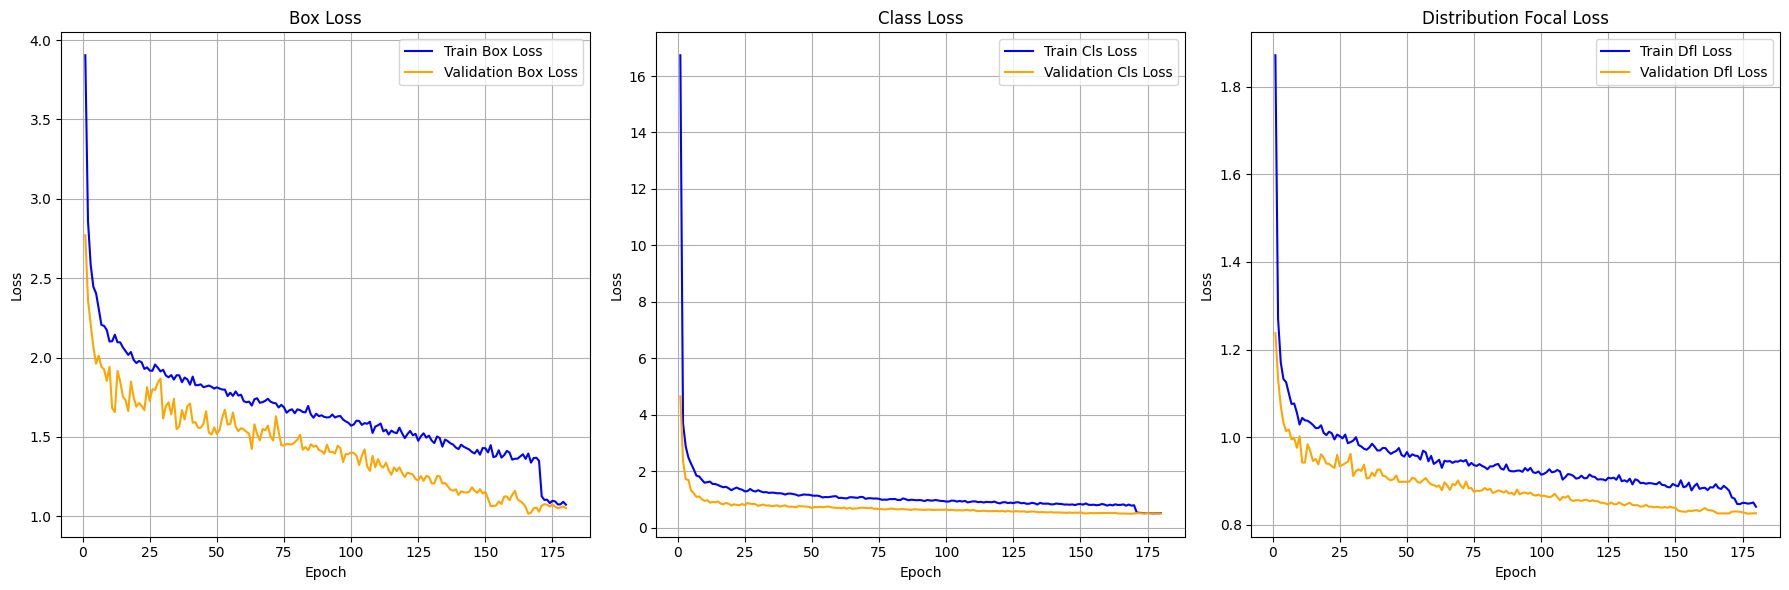

In [33]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [34]:
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/67 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_02.jpg: 640x640 3 missing_holes, 17.5ms
image 2/67 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_08.jpg: 640x640 3 missing_holes, 16.3ms
image 3/67 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_14.jpg: 640x640 3 missing_holes, 16.3ms
image 4/67 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_15.jpg: 640x640 3 missing_holes, 16.3ms
image 5/67 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_16.jpg: 640x640 3 missing_holes, 16.3ms
image 6/67 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_mouse_bite_02.jpg: 640x640 2 mouse_bites, 16.3ms
image 7/67 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_04.jpg: 640x640 3 open_circuits, 16.3ms
image 8/67 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_11.jpg: 640x640 3 open_circuits, 16.3ms
image 9/67 /content/drive/MyDrive/PCB_DATAS

In [35]:
predict_dir = '/content/runs/detect/predict'
dest_predict_dir = os.path.join(root_dir, 'results/predict')

shutil.copytree(predict_dir, dest_predict_dir)

'/content/drive/MyDrive/PCB_DATASET/results/predict'

In [36]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [39]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join(dest_predict_dir, 'labels/11_spurious_copper_01.txt')
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

[[5.0, 0.408254, 0.172748, 0.0224394, 0.0375961, 0.835841],
 [5.0, 0.552209, 0.492025, 0.0324583, 0.0171401, 0.81825],
 [5.0, 0.497904, 0.30507, 0.0198856, 0.0388667, 0.811004],
 [5.0, 0.521123, 0.647202, 0.0161399, 0.0339068, 0.77138],
 [5.0, 0.37454, 0.61523, 0.0277331, 0.0195348, 0.761666]]

In [43]:
pred_annot_df = yolo_to_original_annot('11_spurious_copper_01.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,confidence
0,11_spurious_copper_01.jpg,2282,2248,spurious_copper,906,346,957,430,0.835841
1,11_spurious_copper_01.jpg,2282,2248,spurious_copper,1223,1086,1297,1125,0.818250
2,11_spurious_copper_01.jpg,2282,2248,spurious_copper,1113,642,1158,729,0.811004
3,11_spurious_copper_01.jpg,2282,2248,spurious_copper,1170,1416,1207,1493,0.771380
4,11_spurious_copper_01.jpg,2282,2248,spurious_copper,823,1361,886,1404,0.761666


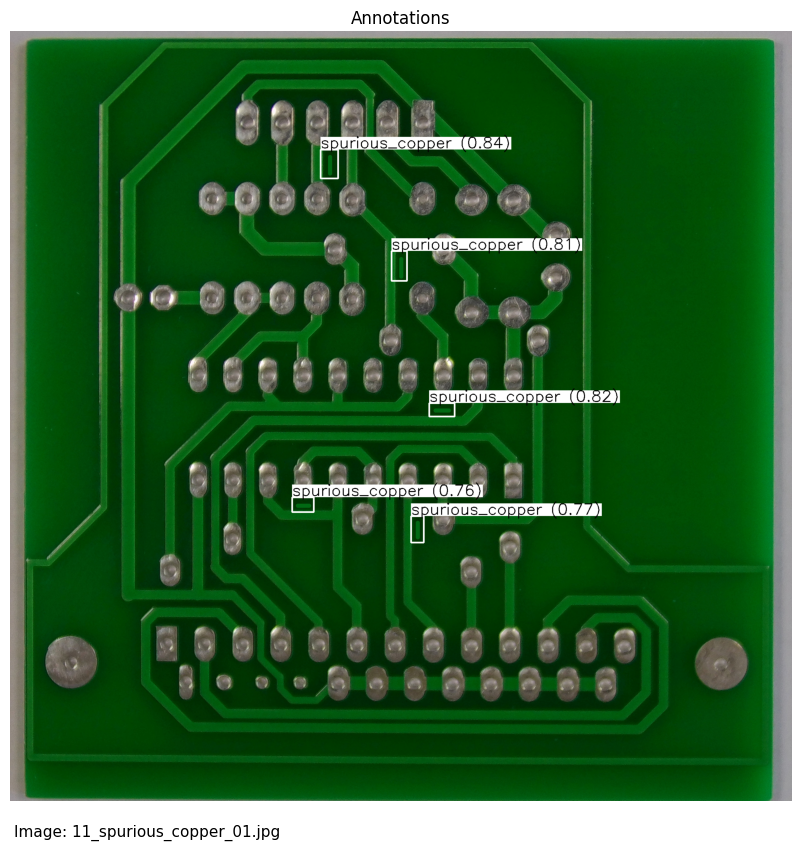

In [44]:
visualize_annotations('11_spurious_copper_01.jpg', images_dir, pred_annot_df, is_subfolder=True);

In [42]:
model.export()

Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from '/content/drive/MyDrive/PCB_DATASET/results/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (21.5 MB)

TorchScript: starting export with torch 2.4.1+cu121...
TorchScript: export success ✅ 2.3s, saved as '/content/drive/MyDrive/PCB_DATASET/results/weights/best.torchscript' (42.9 MB)

Export complete (4.5s)
Results saved to /content/drive/MyDrive/PCB_DATASET/results/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/PCB_DATASET/results/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/content/drive/MyDrive/PCB_DATASET/results/weights/best.torchscript imgsz=640 data=/content/drive/MyDrive/PCB_DATASET/data.yaml  
Visualize:       https://netron.app


'/content/drive/MyDrive/PCB_DATASET/results/weights/best.torchscript'